# Inventory of functions used
A crude inventory of functions used. They're not very portable (a lot of hardcoded stuff), but if there's a need to we can refactor them to be more portable, and make more sense.

In [1]:
from herbie import Herbie, wgrib2, paint
from herbie.toolbox import EasyMap, ccrs, pc
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import numpy as np
import math
import cv2
import requests
import json
import os
import sys
from scipy.interpolate import NearestNDInterpolator, LinearNDInterpolator

## HRRR

### `get_hrrr_data(preloaded)`
- Uses `herbie` to download HRRR-smoke's near-surface smoke field (called "MASSDEN").
    - Note that these are not forecasts; we download the hourly-assimilated data.
- Downloads 7 days of data (1-10 to 1-17), 24 hours (00 to 23) -> 168 hours.
- Returns a list of 168 grib files.

In [2]:
# returns list of grib files (not herbie objects)
# downloads 7 days of data (1-10 to 1-17), 24 hours (00 to 23) -> 168 hours
# not forecasts -- downloading actual hourly updated data
def get_hrrr_data():
    start_day, end_day = 10, 17
    start_hour, end_hour = 0, 24
    grib_files = []
    for day in range(start_day, end_day):
        for hour in range(start_hour, end_hour):
            date = f"2025-01-{str(day).zfill(2)}-{str(hour).zfill(2)}"
            H = Herbie(
                date,
                model="hrrr",
                product="sfc",
            )
            H.download("MASSDEN")
            my_file = H.get_localFilePath("MASSDEN")
            grib_files.append(my_file)
            
    return grib_files

### `subregion_grib_files_to_numpy(grib_files, extent)`
- Arguments:
    - `grib_files`: list of grib files
    - `extent`: (longitude bottom, longitude top, latitude bottom, latitude top)
    - `row`, `col`: the row and column values for the subregion (you kinda just have to know this ahead of time by subregioning the grib and peeking into the xarray dataset values)
- Validates downloads
- Subregions each grib file
- Converts the grib file into xarray, then to numpy
- Returns a numpy array of the grib data

In [3]:
def subregion_grib_files_to_numpy(grib_files, extent, row=30, col=26):
    n_frames = len(grib_files)
    hrrr_subregion_np = np.empty((n_frames, row, col))
    hrrr_subregion_xarr = [None] * n_frames
    for count, file in enumerate(grib_files):
        # subregion the grib files
        idx_file = wgrib2.create_inventory_file(file)    
        subset_file = wgrib2.region(file, extent, name="la_region")
    
        # print progress
        if ((count + 1) % 10 == 0 or count + 1 == len(grib_files)):
            print(f"{count+1}/{len(grib_files)} files converted.")
    
        # store as xarray and numpy
        hrrr_xarr = xr.open_dataset(subset_file, engine="cfgrib", decode_timedelta=False)
        hrrr_subregion_xarr[count] = hrrr_xarr
        hrrr_subregion_np[count] = np.flip(hrrr_xarr.mdens.to_numpy(), axis=0)
        
    return hrrr_subregion_np

### `sliding_window_of(frames, sample_size, rows, cols, channels)`
- Arguments:
    - `frames`: a numpy array of frames
    - `sample_size`: the desired size of a sample
    - `rows`, `cols`: the row and column dimensions of the frame
    - `channels`: the number of channels in the sample
- Creates a sliding window of samples. e.g:
    - 5 frame sample = sample 1: 0-4 frames, sample 2: 1-5 frames, ..., sample n: \[n-1, n-1+4\] frames.
- Returns a numpy array containing the samples 

In [4]:
def sliding_window_of(frames, sample_size, rows, cols, channels):
    n_samples = len(frames) - sample_size
    samples = np.empty((n_samples, sample_size, rows, cols, channels))
    for i in range(n_samples):
        samples[i] = np.array([frames[j] for j in range(i, i + sample_size)])
        
    return samples

### `np_to_final_input(hrrr_subregion_np)`
- Arguments:
    - `hrrr_subregion_np`: a numpy array that contains the hrrr data that has been subject to a subregion.
- Interpolates
- Creates a channel axis
- Creates samples from frames
- Returns the final input for the convlstm

In [5]:
def np_to_final_input(hrrr_subregion_np):
    rows, cols, channels = 40, 40, 1
    n_frames = len(hrrr_subregion_np)
    frames = np.empty(shape=(n_frames, rows, cols, channels))
    
    for i, frame in enumerate(hrrr_subregion_np):
        new_frame = cv2.resize(frame, (rows, cols))
        new_frame = np.reshape(new_frame, (rows, cols, channels))
        frames[i] = new_frame

    complete_dataset = sliding_window_of(frames, 5, rows, cols, channels)
    
    return complete_dataset

## AirNow

### `get_airnow_data()`
- Arguments:
    - bounding box
- Gets AirNow data
- Downloads 7 days of data (1-10 to 1-17), 24 hours (00 to 23) -> 168 hours.
- Returns a list of 168 dataframes of station data.

In [6]:
def get_airnow_data(lon_bottom, lat_bottom, lon_top, lat_top):
    # get airnow data from the EPA
    if os.path.exists('data/airnow.json'):
        print("data/airnow.json already exists; skipping request...")
    else:
        date_start = '2025-01-10T00'
        date_end = '2025-01-16T23'
        bbox = f'{lon_bottom},{lat_bottom},{lon_top},{lat_top}'
        airnow_api_key = print("YOU NEED TO ADD YOUR API KEY!")
        URL = "https://www.airnowapi.org/aq/data"
        
        # location given here
        
        # defining a params dict for the parameters to be sent to the API
        PARAMS = {
            'startDate':date_start,
            'endDate':date_end,
            'parameters':'PM25',
            'BBOX':bbox,
            'dataType':'B',
            'format':'application/json',
            'verbose':'0',
            'monitorType':'2',
            'includerawconcentrations':'1',
            'API_KEY':airnow_api_key
        }
        
        # sending get request and saving the response as response object
        response = requests.get(url = URL, params = PARAMS)
    
        # extracting data in json format
        airnow_data = response.json()
        with open('data/airnow.json', 'w') as file:
            json.dump(airnow_data, file)
            print("JSON data saved to data/airnow.json")
        
    # open json file and convert to dataframe
    with open('data/airnow.json', 'r') as file:
        airnow_data = json.load(file)
    airnow_df = pd.json_normalize(airnow_data)

    # group station data by time
    list_df = [group for name, group in airnow_df.groupby('UTC')]
    
    return list_df

### `preprocess_ground_sites(df, dim, latMax, latMin, lonMax, lonMin)`
- Arguments:
    - `df`: dataframe containing the station data
    - `dim`: the desired dimensions of the grid
    - bounding box data
- Converts the station data into a grid format with the desired dimensions
- Returns the preprocessed frame

In [7]:
def preprocess_ground_sites(df, dim, latMax, latMin, lonMax, lonMin):
    latDist, lonDist = abs(latMax - latMin), abs(lonMax - lonMin)
    unInter = np.zeros((dim,dim))
    dfArr = np.array(df[['Latitude','Longitude','Value']])
    for i in range(dfArr.shape[0]):
        # Calculate x
        x = int(((latMax - dfArr[i,0]) / latDist) * dim)
        if x >= dim:
            x = dim - 1
        if x <= 0:
            x = 0
        # Calculate y
        y = dim - int(((lonMax + abs(dfArr[i,1])) / lonDist) * dim)
        if y >= dim:
            y = dim - 1
        if y <= 0:
            y = 0
        if dfArr[i,2] < 0:
            unInter[x,y] = 0
        else:
            unInter[x,y] = dfArr[i,2]
    return unInter

### `interpolated_frame(f, dim)`
- Arguments:
    - `f`: the frame to be interpolated
    - `dim`: the desired dimensions of the frame
- Returns the given frame, interpolated with IDW

In [8]:
def interpolate_frame(f, dim):
    i = 0
    interpolated = []
    count = 0
    idx = 0
    x_list = []
    y_list = []
    values = []
    for x in range(f.shape[0]):
        for y in range(f.shape[1]):
            if f[x,y] != 0:
                x_list.append(x)
                y_list.append(y)
                values.append(f[x,y])
    coords = list(zip(x_list,y_list))
    try:
        interp = NearestNDInterpolator(coords, values)
        X = np.arange(0,dim)
        Y = np.arange(0,dim)
        X, Y = np.meshgrid(X, Y)
        Z = interp(X, Y)
    except ValueError:
        Z = np.zeros((dim,dim))
    interpolated = Z
    count += 1
    i += 1
    interpolated = np.array(interpolated)
    return interpolated

## ETC

### `std_scale(data)`
- Arguments:
    - `data`, which is a numpy array of data
- Performs standard scaling

In [9]:
# we scale each sample relative to other samples
def std_scale(data):
    mean = np.mean(data)
    stddev = np.std(data)
    return (data - mean) / stddev

# HRRR preprocessing

In [10]:
# define bounding box
lat_bottom, lat_top = 33.6, 34.3
lon_bottom, lon_top = -118.6, -117.9
extent = (lon_bottom, lon_top, lat_bottom, lat_top)
dim = 40

# preprocessing pipeline
grib_dataset = get_hrrr_data()
np_subregion_dataset = subregion_grib_files_to_numpy(grib_dataset, extent)
X_hrrr = np_to_final_input(np_subregion_dataset)

print(X_hrrr.shape)

✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 00:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 01:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 02:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 03:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 04:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 05:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 06:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 07:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 08:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 09:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=sfc ┊ 2025-Jan-10 10:00 UTC F00 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr 

Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_d9ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_87ef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_03ef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_64ef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_10ef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_47ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_6def9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

10/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_5aef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_60ef9dd4__hrrr.t15z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_78ef9dd4__hrrr.t16z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_2aef9dd4__hrrr.t17z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_aeef9dd4__hrrr.t18z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_2bef9dd4__hrrr.t19z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250110/la_region_subset_aeef9dd4__hrrr.t20z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

20/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_d7ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_c0ef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_86ef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_afef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_0bef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_13ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_dbef9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

30/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_b0ef9dd4__hrrr.t10z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_5def9dd4__hrrr.t11z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_b2ef9dd4__hrrr.t12z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_a7ef9dd4__hrrr.t13z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_cdef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_a9ef9dd4__hrrr.t15z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_9aef9dd4__hrrr.t16z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

40/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_6def9dd4__hrrr.t20z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_3bef9dd4__hrrr.t21z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_80ef9dd4__hrrr.t22z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250111/la_region_subset_f2ef9dd4__hrrr.t23z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_bbef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_adef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_08ef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

50/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_d9ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_90ef9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_b6ef9dd4__hrrr.t07z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_9aef9dd4__hrrr.t08z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_3cef9dd4__hrrr.t09z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_44ef9dd4__hrrr.t10z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_e6ef9dd4__hrrr.t11z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

60/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_b1ef9dd4__hrrr.t16z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_e9ef9dd4__hrrr.t17z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_afef9dd4__hrrr.t18z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_c8ef9dd4__hrrr.t19z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_fbef9dd4__hrrr.t20z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_0aef9dd4__hrrr.t21z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250112/la_region_subset_18ef9dd4__hrrr.t22z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

70/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_0fef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_c2ef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_9bef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_34ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_17ef9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_1bef9dd4__hrrr.t07z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_0def9dd4__hrrr.t08z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

80/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_c4ef9dd4__hrrr.t12z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_ddef9dd4__hrrr.t13z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_f3ef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_b3ef9dd4__hrrr.t15z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_53ef9dd4__hrrr.t16z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_d3ef9dd4__hrrr.t17z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_d6ef9dd4__hrrr.t18z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

90/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_4cef9dd4__hrrr.t22z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250113/la_region_subset_21ef9dd4__hrrr.t23z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_d5ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_1def9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_08ef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_c4ef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_beef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

100/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_efef9dd4__hrrr.t08z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_a7ef9dd4__hrrr.t09z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_beef9dd4__hrrr.t10z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_10ef9dd4__hrrr.t11z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_14ef9dd4__hrrr.t12z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_43ef9dd4__hrrr.t13z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_73ef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

110/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_f8ef9dd4__hrrr.t18z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_3def9dd4__hrrr.t19z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_eeef9dd4__hrrr.t20z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_1cef9dd4__hrrr.t21z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_82ef9dd4__hrrr.t22z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250114/la_region_subset_63ef9dd4__hrrr.t23z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_6def9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

120/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_5bef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_fbef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_deef9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_3def9dd4__hrrr.t07z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_15ef9dd4__hrrr.t08z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_12ef9dd4__hrrr.t09z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_5eef9dd4__hrrr.t10z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

130/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_8eef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_16ef9dd4__hrrr.t15z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_82ef9dd4__hrrr.t16z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_91ef9dd4__hrrr.t17z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_7bef9dd4__hrrr.t18z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_22ef9dd4__hrrr.t19z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250115/la_region_subset_d7ef9dd4__hrrr.t20z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

140/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_45ef9dd4__hrrr.t00z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_e3ef9dd4__hrrr.t01z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_faef9dd4__hrrr.t02z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_0eef9dd4__hrrr.t03z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_bdef9dd4__hrrr.t04z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_a8ef9dd4__hrrr.t05z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_37ef9dd4__hrrr.t06z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

150/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_35ef9dd4__hrrr.t10z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_18ef9dd4__hrrr.t11z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_b5ef9dd4__hrrr.t12z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_daef9dd4__hrrr.t13z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_8eef9dd4__hrrr.t14z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_91ef9dd4__hrrr.t15z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_2fef9dd4__hrrr.t16z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/

160/168 files converted.


Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_aaef9dd4__hrrr.t20z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_3bef9dd4__hrrr.t21z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_90ef9dd4__hrrr.t22z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file
Ignoring index file '/home/mgraca/data/hrrr/20250116/la_region_subset_70ef9dd4__hrrr.t23z.wrfsfcf00.grib2.5b7b6.idx' older than GRIB file


168/168 files converted.
(163, 5, 40, 40, 1)


# AirNow preprocessing

In [11]:
# get data, process ground sites, interpolate, create samples
list_df = get_airnow_data(lon_bottom, lat_bottom, lon_top, lat_top)
list_unInter = [preprocess_ground_sites(df, dim, lat_top, lat_bottom, lon_top, lon_bottom) for df in list_df]
list_inter = [interpolate_frame(unInter, dim) for unInter in list_unInter]
frames = np.expand_dims(np.array(list_inter), axis=-1)
X_airnow = sliding_window_of(frames=frames, sample_size=5, rows=dim, cols=dim, channels=1)

print(X_airnow.shape)

data/airnow.json already exists; skipping request...
(163, 5, 40, 40, 1)


# Joint preprocessing
- Create Y dataset
- Combine X datasets into 1 with 2 channels
- Split into train/test sets
- Scale train/test sets independently, and by channel

In [12]:
# generate labels for airnow data
airnow_sens_loc = {
    'Reseda': (5, 4),
    'North Holywood (sic)': (6, 14),
    'Los Angeles - N. Main Street': (13, 22),
    'Compton': (22, 23),
    'Long Beach Signal Hill': (28, 25),
    'Anaheim': (26, 38),
}

n_samples = len(X_airnow)
n_sensors = len(airnow_sens_loc)
Y = np.empty((n_samples, n_sensors))

# if we have 5 frames per sample, the goal is the predict the 6th frame
# this means y should be offset by 5 relative to x
for frame in range(len(Y)):
    for sensor, loc in enumerate(airnow_sens_loc):
        x, y = airnow_sens_loc[loc]
        Y[frame][sensor] = list_unInter[frame+5][x][y]
        
print(Y.shape)

(163, 6)


In [13]:
# for now we'll just scale first, as per the pwwwb nb
X_hrrr = std_scale(X_hrrr)
X_airnow = std_scale(X_airnow)

# combine by adding a new channel
X = np.concatenate([X_hrrr, X_airnow], axis=-1)
print("HRRR and AirNow, combined by channel:", X.shape)

# split data into training and validation sets
split_idx = int(len(X) * 0.75)
X_train, X_test = X[0:split_idx], X[split_idx:]
y_train, y_test = Y[0:split_idx], Y[split_idx:]
print("X_train/test dataset shape:", X_train.shape, X_test.shape)
print("y_train/test dataset shape:", y_train.shape, y_test.shape)

HRRR and AirNow, combined by channel: (163, 5, 40, 40, 2)
X_train/test dataset shape: (122, 5, 40, 40, 2) (41, 5, 40, 40, 2)
y_train/test dataset shape: (122, 6) (41, 6)


# Final input viz

Displaying frames for example 102.


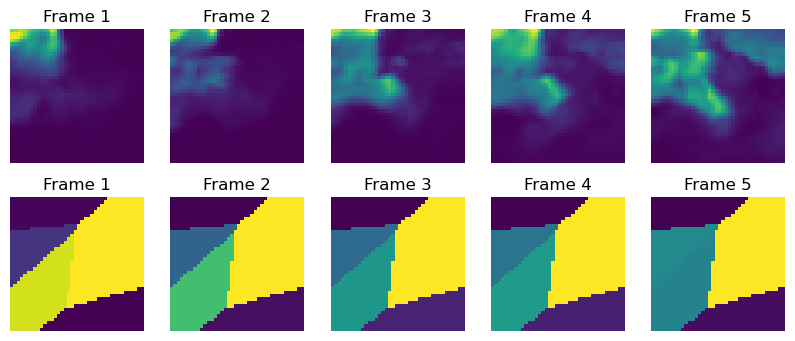

Target:  [ 2.  11.1 11.2 19.7  0.   4.8]


In [14]:
# Construct a figure on which we will visualize the images.
fig, axes = plt.subplots(2, 5, figsize=(10, 4))

# Plot each of the sequential images for one random data example.
# plot hrrr channel
np.random.seed(42)
rand_sample = np.random.choice(range(len(X_train)), size=1)[0]
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(X_train[rand_sample, idx, :, :, 0]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")
# plot airnow channel
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(X_train[rand_sample, idx, :, :, 1]))
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying frames for example {rand_sample}.")
plt.show()

print("Target: ", y_train[rand_sample])

# Model

In [15]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import BatchNormalization
from keras.layers import Convolution2D, MaxPooling3D, Flatten, Reshape
from keras.layers import TimeDistributed
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import InputLayer

2025-04-03 18:14:41.943922: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-03 18:14:41.951726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743729281.962654   66745 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743729281.966010   66745 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-03 18:14:41.976412: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [16]:
tf.keras.backend.set_image_data_format('channels_last')

seq = Sequential()

seq.add(
    InputLayer(shape=(5, 40, 40, 2))
)

seq.add(
    ConvLSTM2D(
            filters=15, 
            kernel_size=(3, 3),
            padding='same', 
            return_sequences=True
    )
)

seq.add(
    ConvLSTM2D(
        filters=30, 
        kernel_size=(3, 3),
        padding='same', 
        return_sequences=True
    )
)

seq.add(
    Conv3D(
        filters=15, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'    
    )
)

seq.add(
    Conv3D(
        filters=1, 
        kernel_size=(3, 3, 3),
        activation='relu',
        padding='same'
    )
)

seq.add(Flatten())

seq.add(Dense(6,activation='relu'))

seq.compile(loss='mean_absolute_error', optimizer='adam')
seq.summary()

I0000 00:00:1743729283.074270   66745 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6495 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_lstm2d (ConvLSTM2D)        │ (None, 5, 40, 40, 15)  │         9,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_1 (ConvLSTM2D)      │ (None, 5, 40, 40, 30)  │        48,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d (Conv3D)                 │ (None, 5, 40, 40, 15)  │        12,165 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv3d_1 (Conv3D)               │ (None, 5, 40, 40, 1)   │           406 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │        48,006 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,537 (463.04 KB)

 Trainable params: 118,537 (463.04 KB)

 Non-trainable params: 0 (0.00 B)

# Train and test

In [17]:
seq.fit(X_train, y_train, batch_size=16, epochs=150)

Epoch 1/150


I0000 00:00:1743729285.533933   69866 service.cc:148] XLA service 0x73cf24004850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743729285.533951   69866 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2025-04-03 18:14:45.586071: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1743729285.844645   69866 cuda_dnn.cc:529] Loaded cuDNN version 90800
2025-04-03 18:14:46.203251: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[16,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backen

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 13.1578

I0000 00:00:1743729287.827194   69866 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2025-04-03 18:14:48.486083: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[10,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[10,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[10,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-03 18:14:48.604642: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[10,15,40,40]{3,2,1,0}, u8[0]{0}

8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 308ms/step - loss: 12.7085
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.8032
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 6.2620
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.6010
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.1974
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.9608
Epoch 7/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.3802
Epoch 8/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.3423
Epoch 9/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 5.0336
Epoch 10/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.9484
Epoch 11/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.4683
Epoch 12/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.4830
Epoch 13/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 4.0848
Epoch 14/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.9889
Epoch 15/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 3.3550
Epoch 16/150
8/8 ━━━━━━━━━━━━

In [18]:
y_pred = seq.predict(X_test, verbose=0)
print(y_test.shape, y_pred.shape)

2025-04-03 18:15:23.119130: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,15,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,2,40,40]{3,2,1,0}, f32[15,2,3,3]{3,2,1,0}, f32[15]{0}, f32[32,15,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":1},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-04-03 18:15:23.170597: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,30,40,40]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,15,40,40]{3,2,1,0}, f32[30,15,3,3]{3,2,1,0}, f32[30]{0}, f32[32,30,40,40]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01-

(41, 6) (41, 6)


In [22]:
from skimage.metrics import mean_squared_error as mse

def mserr(y_pred, y_test):
    ep = 0.45
    return ep + 0.002*mse(y_pred, y_test)

def rmse(y_pred, y_test):
    return np.sqrt(mserr(y_pred, y_test))

def nrmse(y_pred, y_test):
    return np.sqrt(mserr(y_pred, y_test)) / np.mean(y_test) * 100
    
print("Input: Interpolated Previous PM2.5 Sensor data + HRRR-smoke data")
print("Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) \n")

print("RESULTS")
print("---------------------------------------------------------------------------")
print(f"All Days All Locations - y_pred vs y_test Raw RMSE: {rmse(y_pred, y_test):.2f}")
print(f"All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: {nrmse(y_pred, y_test):.2f}%\n")

print("RESULTS BY FRAME")
print("---------------------------------------------------------------------------")
for i in range(5):
    print(f"Frame {i+1} (Hour {i+1}) All Locations - Raw RMSE: {rmse(y_pred[i,:], y_test[i,:]):.2f}")
    print(f"Frame {i+1} (Hour {i+1}) All Locations - RMSE Percent Error of Mean: {nrmse(y_pred[i,:], y_test[i,:]):.2f}%\n")

print("RESULTS BY SENSOR LOCATION")
print("---------------------------------------------------------------------------")
for i, loc in enumerate(list(airnow_sens_loc.keys())):
    print(f"All Days - {loc} Raw RMSE: {rmse(y_pred[:,i], y_test[:,i]):.2f}")
    print(f"All Days - {loc} RMSE Percent Error of Mean: {nrmse(y_pred[:,i], y_test[:,i]):.2f}%\n")

Input: Interpolated Previous PM2.5 Sensor data + HRRR-smoke data
Output: Future PM 2.5 Sensor data at 6 Locations in LA County Hourly (Using 5 previous frames to predict 5 future frames) 

RESULTS
---------------------------------------------------------------------------
All Days All Locations - y_pred vs y_test Raw RMSE: 0.71
All Days All Locations - y_pred vs y_test RMSE Percent Error of Mean: 7.17%

RESULTS BY FRAME
---------------------------------------------------------------------------
Frame 1 (Hour 1) All Locations - Raw RMSE: 0.68
Frame 1 (Hour 1) All Locations - RMSE Percent Error of Mean: 5.63%

Frame 2 (Hour 2) All Locations - Raw RMSE: 0.70
Frame 2 (Hour 2) All Locations - RMSE Percent Error of Mean: 5.83%

Frame 3 (Hour 3) All Locations - Raw RMSE: 0.70
Frame 3 (Hour 3) All Locations - RMSE Percent Error of Mean: 6.00%

Frame 4 (Hour 4) All Locations - Raw RMSE: 0.71
Frame 4 (Hour 4) All Locations - RMSE Percent Error of Mean: 5.87%

Frame 5 (Hour 5) All Locations - Raw

# Thoughts
- idk what `mserr` is doing, what's with this extra computation doing here? what not just basic `mse`?
- strictly speaking, I don't think we're "using the previous 5 frames to predict 5 future frames". We're using the 5 previous frames to predict the future values of the 6 stations in the next hour. It's not like a classic seq2seq model where 5 frames predict the next frame, then the next prediction uses 4+1 frames to predict the frame after, etc. To do that, we'll have to do next frame prediction (create a new hrrr frame and interpolated airnow sensor frame?